In [ ]:
#|default_exp mixtures

In [1]:
#|export
import jax
import jax.numpy as jnp
from jax import jit
import genjax
from genjax import gen
from genjax.generative_functions.distributions import ExactDensity, Distribution
from dataclasses import dataclass
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)

In [3]:
def viz_it(key, dist, args, N=1_000, bins=100):
    _,key = jax.random.split(key)
    n = len(args)
    sample = jit(jax.vmap(dist.sample, (0,) +n*(None,)))
    eval   = jit(jax.vmap(dist.logpdf, (0,) +n*(None,)))

    
    keys = jax.random.split(key, N)
    ss = sample(keys, *args)

    xs = jnp.linspace(jnp.min(ss)-1, jnp.max(ss)+1, 2_000)
    ys = eval(xs, *args)

    # -----------------
    plt.figure(figsize=(5,2))
    plt.title(f"{dist.__class__.__name__}")
    plt.hist(ss, bins=bins, density=True, label="Sample\nDensity", color="C0", alpha=0.5);
    plt.plot(xs, jnp.exp(ys), label="PDF", c="k", linestyle="-");
    plt.legend();
    plt.show()

In [5]:
def _bench_it(key, sample, eval, args, M=None):

    _,key = jax.random.split(key)

    if M == None:

        # Warmup
        key, = jax.random.split(key,1);
        x = sample(key, *args)
        eval(x, *args)

        # Benchmark
        key, = jax.random.split(key,1);
        t_sample = %timeit -o -q -r 1 -n 1 sample(key, *args);

        x = sample(key, *args)
        t_eval   = %timeit -o -q -r 1 -n 1 eval(x, *args);
        

    else:

        # Warmup
        keys = jax.random.split(key, M);
        x = sample(keys, *args)
        eval(x, *args)

        # Benchmark
        key, = jax.random.split(key,1);
        keys = jax.random.split(key, M);
        t_sample = %timeit -o -q -r 1 -n 1 sample(keys, *args);

        x = sample(keys, *args)
        t_eval   = %timeit -o -q -r 1 -n 1 eval(x, *args);
    
    # Print
    print(f" {t_sample}")
    print(f" {t_eval}")
    print("")

    return t_sample, t_eval

def bench_it(key, dist, args, M=10_000):
    _,key = jax.random.split(key)
    n = len(args)

    print(f"{dist.__class__.__name__} (Fixed Args)")

    #
    # SINGLE
    #
    print("SINGLE")
    sample = dist.sample
    eval   = dist.logpdf
    _,key = jax.random.split(key)
    _bench_it(key, sample, eval, args, M=None)



    #
    # SINGLE + JIT
    #
    print("SINGLE + JIT")
    sample = jit(dist.sample)
    eval   = jit(dist.logpdf)
    _,key = jax.random.split(key)
    _bench_it(key, sample, eval, args, M=None)

    #
    # VMAP
    #
    print("VMAP")
    sample = jax.vmap(dist.sample, (0,) +n*(None,))
    eval   = jax.vmap(dist.logpdf, (0,) +n*(None,))
    _,key = jax.random.split(key)
    _bench_it(key, sample, eval, args, M=M)

    #
    # VMAP + JIT
    #
    print("VMAP + JIT")
    sample = jit(jax.vmap(dist.sample, (0,) +n*(None,)))
    eval   = jit(jax.vmap(dist.logpdf, (0,) +n*(None,)))
    _,key = jax.random.split(key)
    _bench_it(key, sample, eval, args, M=M)
    

## Mixtures

### Heterogeneous Mixture

In [3]:
#|export
class HeterogeneousMixture(ExactDensity):
    def __init__(self, dists, *args, **kwargs):        
        assert isinstance(dists, list)
        assert all([isinstance(d, Distribution) for d in dists])        

        self.dists = dists
        super().__init__(*args, **kwargs)

    def sample(self, key, ws, args):
        _,key = jax.random.split(key)
        i = genjax.categorical.sample(key, jnp.array(ws))
        key, = jax.random.split(key,1)

        sampler = lambda d,a: lambda k: d.sample(k, *a)
        distr_branches = [sampler(d,a) for d,a in zip(self.dists, args)]
    
        return jax.lax.switch(i, distr_branches, key)

    def logpdf(self, x, ws, args):
        logps  = jnp.array([d.logpdf(x, *a) for d,a in zip(self.dists, args)])
        logps += jnp.log(ws)
        logp  = jax.scipy.special.logsumexp(logps)
        return logp
    
    def flatten(self):
        return (self.dists,), ()
    
    def __str__(self):
        s = ", ".join([
            f"{str(d):.12s}{'.'*3*(len(str(d))>12)}" 
                for d in self.dists])
        return f"HeterogeneousMixture({s})"

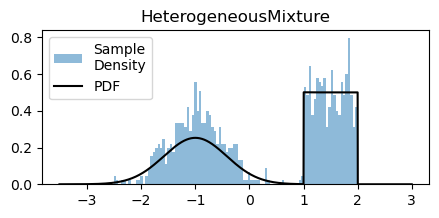

HeterogeneousMixture (Fixed Args)
SINGLE
 210 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 8.99 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SINGLE + JIT
 205 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 125 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP
 49.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 28.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP + JIT
 162 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 152 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [8]:
mix  = HeterogeneousMixture([genjax.normal, genjax.tfp_uniform])

ws   = jnp.array([0.5, 0.5])
args = [
    jnp.array([-1.0, .5]), 
    jnp.array([1.0, 2.0])
]

viz_it(key, mix, (ws,args), N=1_000, bins=100)
bench_it(key, mix, (ws,args), M=1_000)

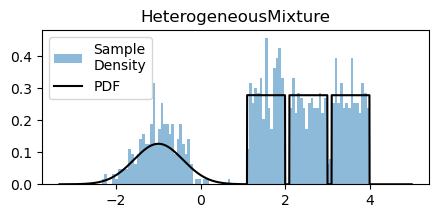

HeterogeneousMixture (Fixed Args)
SINGLE
 303 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 11.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SINGLE + JIT
 215 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 118 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP
 96.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 45.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP + JIT
 185 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 136 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [9]:
mix  = HeterogeneousMixture([
    genjax.normal,
    genjax.tfp_uniform,
    genjax.tfp_uniform,
    genjax.tfp_uniform
])

assert isinstance(mix, Distribution)
assert isinstance(mix, ExactDensity)

ws   = jnp.array([0.25, 0.25, .25, .25])
args = [ 
    jnp.array([-1.0, .5]), 
    jnp.array([1.1, 2.0]),
    jnp.array([2.1, 3.0]),
    jnp.array([3.1, 4.0])
]

viz_it(key, mix, (ws,args), N=1_000, bins=100)
bench_it(key, mix, (ws,args), M=1_000)

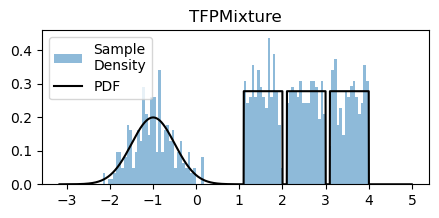

TFPMixture (Fixed Args)
SINGLE
 40.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 17.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SINGLE + JIT
 191 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 123 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP
 76.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 51.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP + JIT
 201 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 135 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [10]:
mix = genjax.tfp_mixture(genjax.tfp_categorical, [
    genjax.tfp_normal, 
    genjax.tfp_uniform,
    genjax.tfp_uniform,
    genjax.tfp_uniform
])
ws   = jnp.array([0.25, 0.25, .25, .25])
args = [ 
    jnp.array([-1.0, .5]), 
    jnp.array([1.1, 2.0]),
    jnp.array([2.1, 3.0]),
    jnp.array([3.1, 4.0])
]


viz_it(key, mix, (ws,args), N=1_000, bins=100)
bench_it(key, mix, (ws,args), M=1_000)

## Homogeneous Mixture

In [11]:
class HomogeneousMixture(ExactDensity):
    def __init__(self, dist, *args, **kwargs):
        assert isinstance(dist, Distribution)
        self.dist = dist
        super().__init__(*args, **kwargs)

    def sample(self, key, ws, args):
        _,key = jax.random.split(key)
        i = genjax.categorical.sample(key, ws)
        key, = jax.random.split(key,1)
        return self.dist.sample(key, *args[i])

    def logpdf(self, x, ws, args):
        n = len(args.T)

        logps = jax.vmap(self.dist.logpdf, (None,) + n*(0,))(x, *args.T)
        logp = jax.scipy.special.logsumexp(logps + jnp.log(ws))
        return logp
    

    def flatten(self):
        return (self.dist,), ()


    def __str__(self):
        s = str(self.dist)
        too_long = len(s) > 12
        return f"HomogeneousMixture({s:.12s}{'.'*3*(too_long)})"

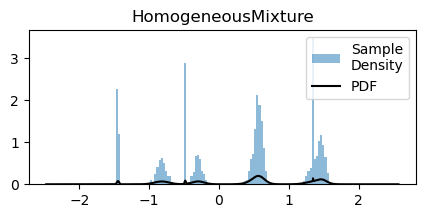

HomogeneousMixture (Fixed Args)
SINGLE
 4.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 11.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SINGLE + JIT
 159 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 98.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP
 17.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 20.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP + JIT
 162 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 108 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [12]:
mix  = HomogeneousMixture(genjax.normal)

assert isinstance(mix, Distribution)
assert isinstance(mix, ExactDensity)


key, = jax.random.split(key,1)
n = 10
ws   = jnp.ones(n)/n
args = jax.random.uniform(key, (n,2))
args = jnp.stack([3*(args[:,0]-0.5), 0.1*args[:,1]], axis=1)

viz_it(key, mix, (ws,args), N=2_000, bins=100)
bench_it(key, mix, (ws,args), M=1_000)

In [13]:
mix = HomogeneousMixture(genjax.normal)

@genjax.gen
def func(mus, sigs):
    args = jnp.stack([mus, sigs], axis=1)
    ws = jnp.ones(len(args))/len(args)
    
    x = HomogeneousMixture(genjax.normal)(ws, args) @ "x"
    return x

mus  = 10*jax.random.uniform(key, (n,))
sigs = jax.random.uniform(key, (n,))

key, tr = func.simulate(key, (mus, sigs))
tr


BuiltinTrace(gen_fn=BuiltinGenerativeFunction(source=<function func at 0x7f5190253790>), args=(Array([7.000265 , 5.3561115, 6.1319017, 4.2216325, 9.748488 , 6.786708 ,
       5.868056 , 4.818392 , 1.5345144, 7.691861 ], dtype=float32), Array([0.7000265 , 0.53561115, 0.6131902 , 0.42216325, 0.97484887,
       0.67867076, 0.5868056 , 0.48183918, 0.15345144, 0.76918614],      dtype=float32)), retval=Array(6.227598, dtype=float32), choices=Trie(inner={'x': DistributionTrace(gen_fn=HomogeneousMixture(), args=(Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32), Array([[7.000265  , 0.7000265 ],
       [5.3561115 , 0.53561115],
       [6.1319017 , 0.6131902 ],
       [4.2216325 , 0.42216325],
       [9.748488  , 0.97484887],
       [6.786708  , 0.67867076],
       [5.868056  , 0.5868056 ],
       [4.818392  , 0.48183918],
       [1.5345144 , 0.15345144],
       [7.691861  , 0.76918614]], dtype=float32)), value=Array(6.227598, dtype=float32), score=Array(-1.7114187, dtype=

## Products

### Homogeneous Product

In [14]:
class HomogeneousProduct(ExactDensity):
    def __init__(self, dist, *args, **kwargs):
        self.dist = dist
        super().__init__(*args, **kwargs)

    def sample(self, key, args):
        keys = jax.random.split(key, len(args))
        return jax.vmap(self.dist.sample)(keys, *args.T)

    def logpdf(self, xs, args):
        return jnp.sum(jax.vmap(self.dist.logpdf)(xs, *args.T))
    
    def flatten(self):
        return (self.dist,), ()

        
class Product(object):
   def __new__(self, D, *args, **kwargs):
        if isinstance(D, Distribution):
            return HomogeneousProduct(D, *args, **kwargs)
        else:
            raise NotImplementedError("Heterogeneous products not implemented yet")

In [15]:

def HomogeneousProduct(dist):
    class X(ExactDensity):
        def sample(self, key, args):
            keys = jax.random.split(key, len(args))
            return jax.vmap(dist.sample)(keys, *args.T)

        def logpdf(self, xs, args):
            return jnp.sum(jax.vmap(dist.logpdf)(xs, *args.T))
        
        # def flatten(self):
            # return (self.dist,), ()

    return X()
        
class Product(object):
   def __new__(self, D, *args, **kwargs):
        if isinstance(D, Distribution):
            return HomogeneousProduct(D, *args, **kwargs)
        else:
            raise NotImplementedError("Heterogeneous products not implemented yet")

In [16]:
prod = HomogeneousProduct(genjax.normal)

n = 100**2
key, = jax.random.split(key,1)
args = jax.random.uniform(key, (n,2))

bench_it(key, prod, [args], M=1_000)

X (Fixed Args)
SINGLE
 3.99 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 8.88 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

SINGLE + JIT
 139 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 96.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP
 6.79 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 12.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

VMAP + JIT
 138 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
 90.6 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [17]:
prod = HomogeneousProduct(genjax.normal)
isinstance(prod, ExactDensity)

True

In [18]:
@genjax.gen
def func(args):
    x = prod(args) @ "x"
    return x

n = 100**2
key, = jax.random.split(key,1)
args = jax.random.uniform(key, (n,2))
key = jax.random.split(key,1)[0]

func.simulate(key, (args,))

(Array([1275157301, 3903859326], dtype=uint32),
 BuiltinTrace(gen_fn=BuiltinGenerativeFunction(source=<function func at 0x7f51900e05e0>), args=(Array([[0.94757867, 0.61204123],
        [0.77032506, 0.2566532 ],
        [0.14849663, 0.7565422 ],
        ...,
        [0.12152672, 0.04980993],
        [0.65256345, 0.43836212],
        [0.9657799 , 0.39965284]], dtype=float32),), retval=Array([0.84530926, 1.5368937 , 0.11048913, ..., 0.11828105, 1.2677121 ,
        0.43974388], dtype=float32), choices=Trie(inner={'x': DistributionTrace(gen_fn=HomogeneousProduct.<locals>.X(), args=(Array([[0.94757867, 0.61204123],
        [0.77032506, 0.2566532 ],
        [0.14849663, 0.7565422 ],
        ...,
        [0.12152672, 0.04980993],
        [0.65256345, 0.43836212],
        [0.9657799 , 0.39965284]], dtype=float32),), value=Array([0.84530926, 1.5368937 , 0.11048913, ..., 0.11828105, 1.2677121 ,
        0.43974388], dtype=float32), score=Array(-10248.263, dtype=float32))}), cache=Trie(inner={}), s

In [19]:
from genjax._src.generative_functions.distributions.distribution import Product

n = 4
key, = jax.random.split(key,1)
args = jax.random.uniform(key, (n,2))


prod = Product.new(*[genjax.normal]*len(args))
_,(tw,r) = prod.random_weighted(key, *args)
tw

Array(-3.4395335, dtype=float32)

### Heterogeneous Product - TODO